In [29]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/developer-productivity-syncora/Developer_Productivity_Synthetic_Syncora(in).csv


This cell confirms the runtime environment (Kaggle in this case), imports essential libraries like NumPy and Pandas, and lists the available input files.

numpy → numerical computations

pandas → data loading and tabular manipulation

os.walk() → iterates through the Kaggle input directory to display all available datasets.
This ensures we can access and load the dataset correctly before proceeding with analysis.
seaborn, matplotlib.pyplot → for plots and visualizations.

train_test_split, StratifiedKFold, cross_validate → splitting dataset and performing cross-validation.

StandardScaler, ColumnTransformer, Pipeline → preprocessing pipelines.

SimpleImputer → handling missing values.

RandomForestClassifier → core machine learning model for classification.

accuracy_score, f1_score, roc_auc_score, etc. → evaluation metrics.
By consolidating these imports, we set up the full ML toolkit required for EDA, modeling, and evaluation.

In [30]:
import warnings, os
warnings.filterwarnings("ignore")



import seaborn as sns
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, StratifiedKFold, cross_validate, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    accuracy_score, f1_score, precision_score, recall_score,
    roc_auc_score, roc_curve, auc, classification_report
)


**We print the shape of the dataset (rows × columns).**
Helps us understand dataset size.
Indicates how many samples and features we are dealing with.
This is an important sanity check to confirm the dataset loaded properly.

In [31]:
print("Dataset shape:", df.shape)

Dataset shape: (2000, 9)


**We display the first 5 rows using df.head().**
This allows us to:
Verify that the dataset structure matches expectations.
Quickly inspect column names, feature types, and sample values.
Spot any unusual encodings or formatting issues early.

In [32]:
print("\nFirst 5 rows:\n", df.head())


First 5 rows:
    hours_coding  coffee_intake_mg  distractions  sleep_hours  commits  \
0      5.190476               575             6     7.467749        6   
1      3.069862               320             1     6.483703        0   
2      5.052262               532             3     9.687784        9   
3      3.694441               359             4     8.150044        3   
4      6.883442               601             4     8.902919        5   

   bugs_reported  ai_usage_hours  cognitive_load  task_success  
0              1        0.729743        3.666136             1  
1              2        0.086857        3.449533             0  
2              1        0.514440        1.509259             1  
3              0        1.226923        4.099178             0  
4              0        0.661380        3.784728             1  


In [33]:
print("\nData Types & Missing Values:\n")
print(df.info())


Data Types & Missing Values:

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 9 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   hours_coding      2000 non-null   float64
 1   coffee_intake_mg  2000 non-null   int64  
 2   distractions      2000 non-null   int64  
 3   sleep_hours       2000 non-null   float64
 4   commits           2000 non-null   int64  
 5   bugs_reported     2000 non-null   int64  
 6   ai_usage_hours    2000 non-null   float64
 7   cognitive_load    2000 non-null   float64
 8   task_success      2000 non-null   int64  
dtypes: float64(4), int64(5)
memory usage: 140.8 KB
None


In [34]:
print("\nMissing values per column:\n", df.isnull().sum())


Missing values per column:
 hours_coding        0
coffee_intake_mg    0
distractions        0
sleep_hours         0
commits             0
bugs_reported       0
ai_usage_hours      0
cognitive_load      0
task_success        0
dtype: int64


**We use df.describe() to generate summary statistics of all numerical features.**

Metrics include mean, standard deviation, min, max, and quartiles (25%, 50%, 75%).

This helps us detect skewness, outliers, and overall feature scales.
If categorical variables exist, include="all" ensures they are also summarized.

In [35]:
print("\nSummary Statistics:\n", df.describe(include="all"))


Summary Statistics:
        hours_coding  coffee_intake_mg  distractions  sleep_hours      commits  \
count   2000.000000       2000.000000    2000.00000  2000.000000  2000.000000   
mean       5.006187        461.120000       2.96000     6.960147     4.700000   
std        1.966547        144.722558       1.66847     1.476519     2.657354   
min       -0.208322         27.000000       0.00000     2.750789     0.000000   
25%        3.690653        374.000000       2.00000     6.029423     3.000000   
50%        5.031464        500.000000       3.00000     6.989199     5.000000   
75%        6.323190        590.000000       4.00000     7.993181     6.000000   
max       12.269495        636.000000       8.00000    10.210599    13.000000   

       bugs_reported  ai_usage_hours  cognitive_load  task_success  
count    2000.000000     2000.000000     2000.000000   2000.000000  
mean        0.816000        1.512217        4.525198      0.618000  
std         1.065228        1.091252     

**Extracting Numeric Columns**

We identify and isolate numeric columns using select_dtypes().Ensures we can later compute correlations, run models, and apply scaling correctly.

Helps distinguish numerical features from categorical ones.

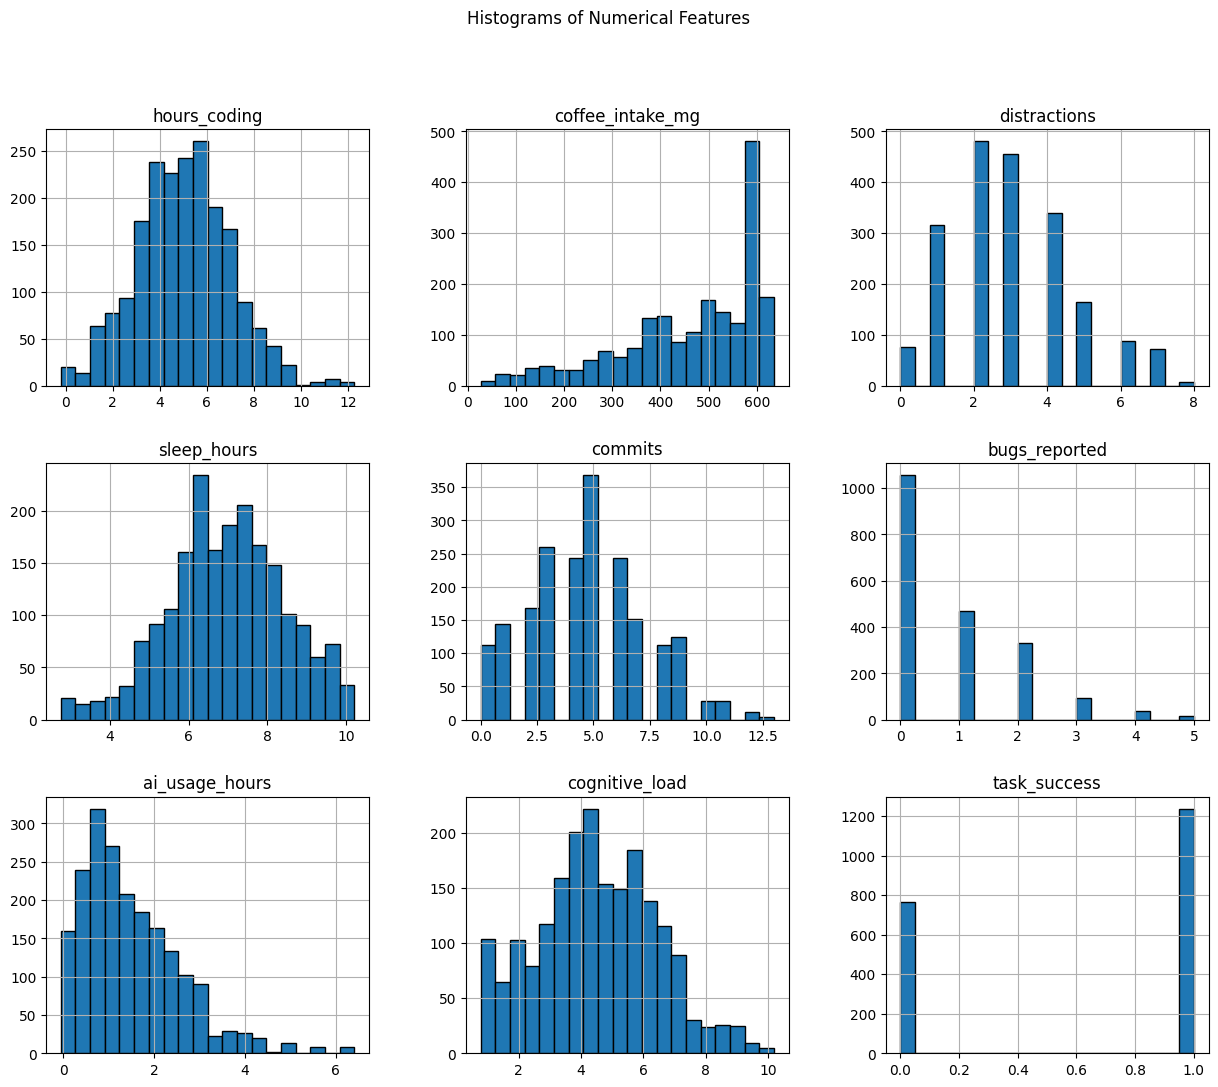

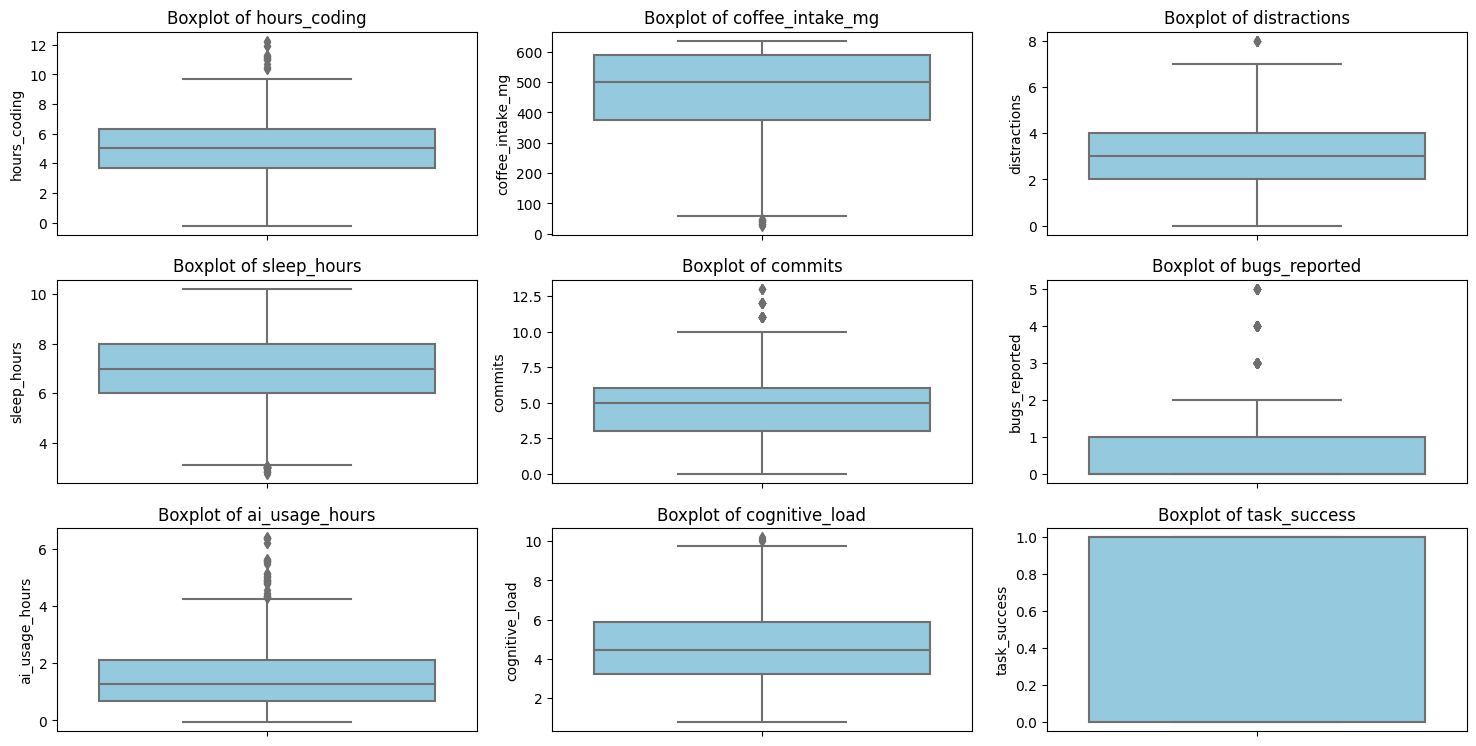

In [36]:
num_cols = df.select_dtypes(include=[np.number]).columns.tolist()
df[num_cols].hist(bins=20, figsize=(15,12), edgecolor='black')
plt.suptitle("Histograms of Numerical Features")
plt.show()

# ====== Boxplots to check outliers ======
plt.figure(figsize=(15, 10))
for i, col in enumerate(num_cols, 1):
    plt.subplot(len(num_cols)//3 + 1, 3, i)
    sns.boxplot(y=df[col], color="skyblue")
    plt.title(f"Boxplot of {col}")
plt.tight_layout()
plt.show()



**Calculate pairwise correlations among numerical features and visualize them using a heatmap.**

High correlation between two features → potential multicollinearity (which may reduce model interpretability).

Helps us understand which features are strongly linked to task_success.

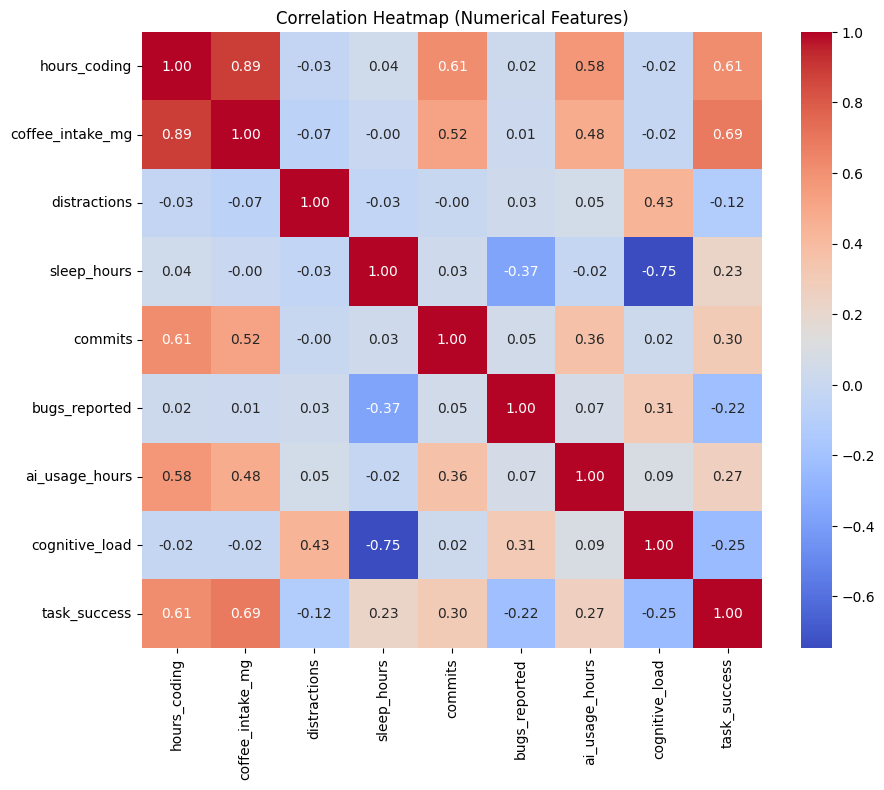

In [37]:
# ====== Correlation Heatmap ======
plt.figure(figsize=(10,8))
corr = df[num_cols].corr()
sns.heatmap(corr, annot=True, fmt=".2f", cmap="coolwarm", cbar=True)
plt.title("Correlation Heatmap (Numerical Features)")
plt.show()

**Pairplot Analysis**

We use Seaborn’s pairplot to visualize scatterplots and distributions of selected numerical features, colored by the target (task_success).Reveals class separation in feature space.

Highlights clusters, trends, and relationships between variables.This is a powerful visual check for linearity and class separability.

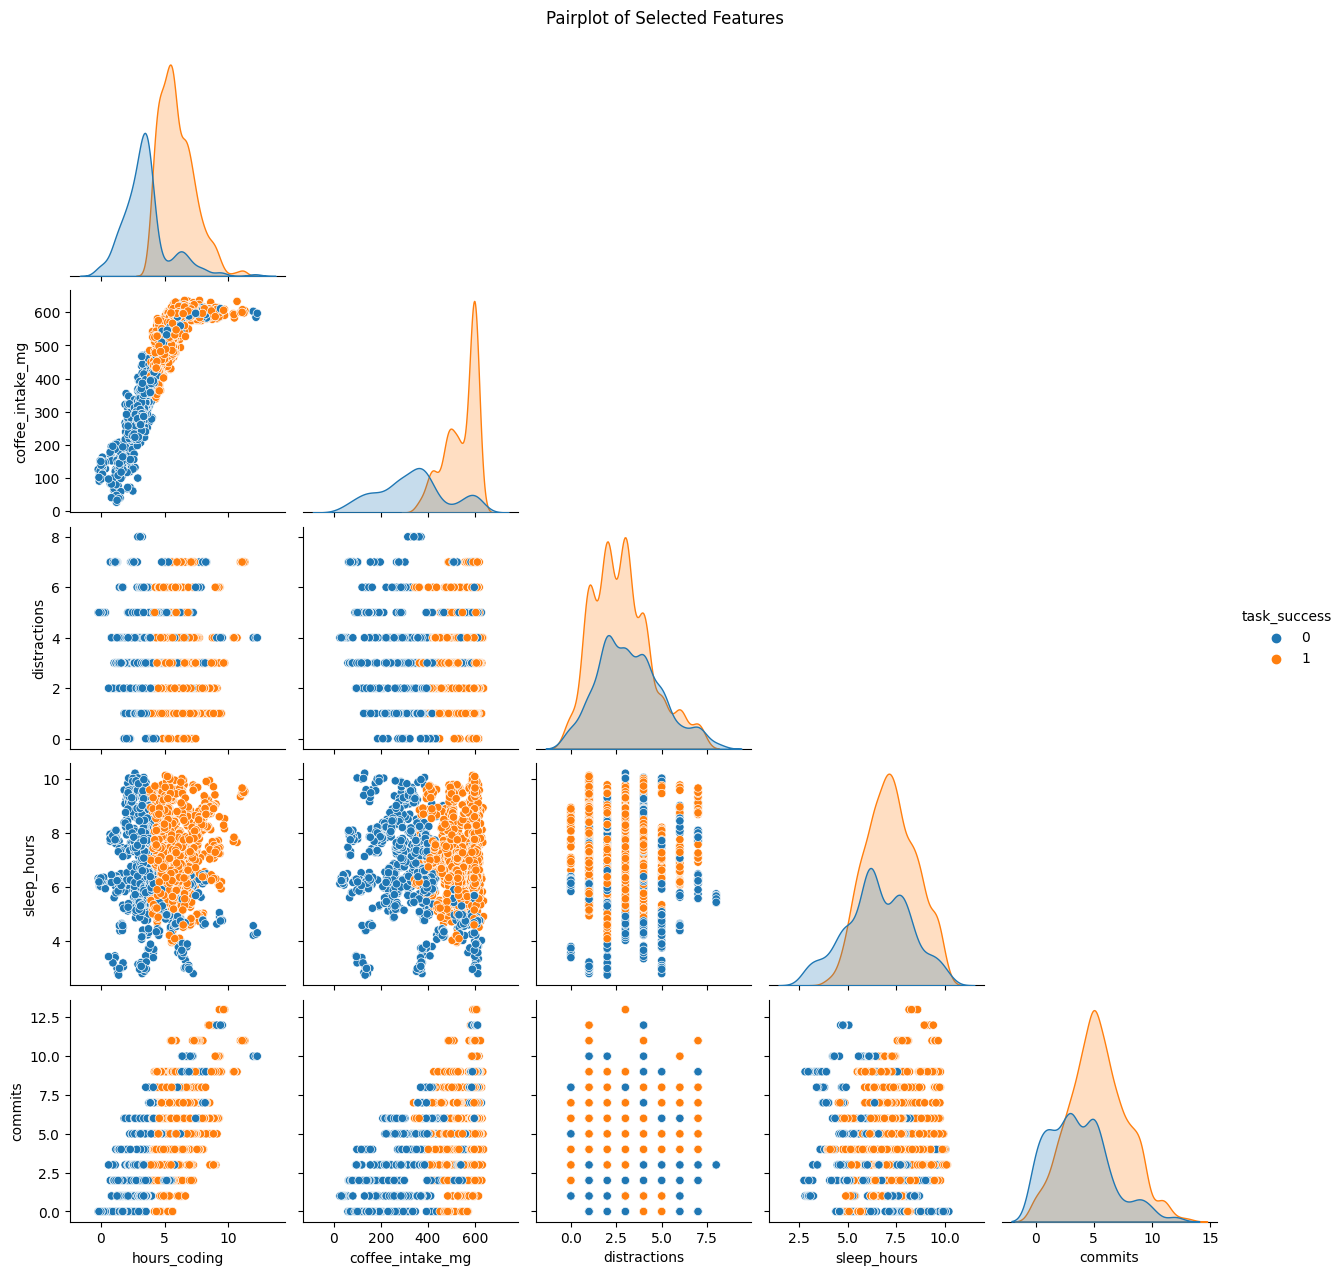

<Figure size 1000x600 with 0 Axes>

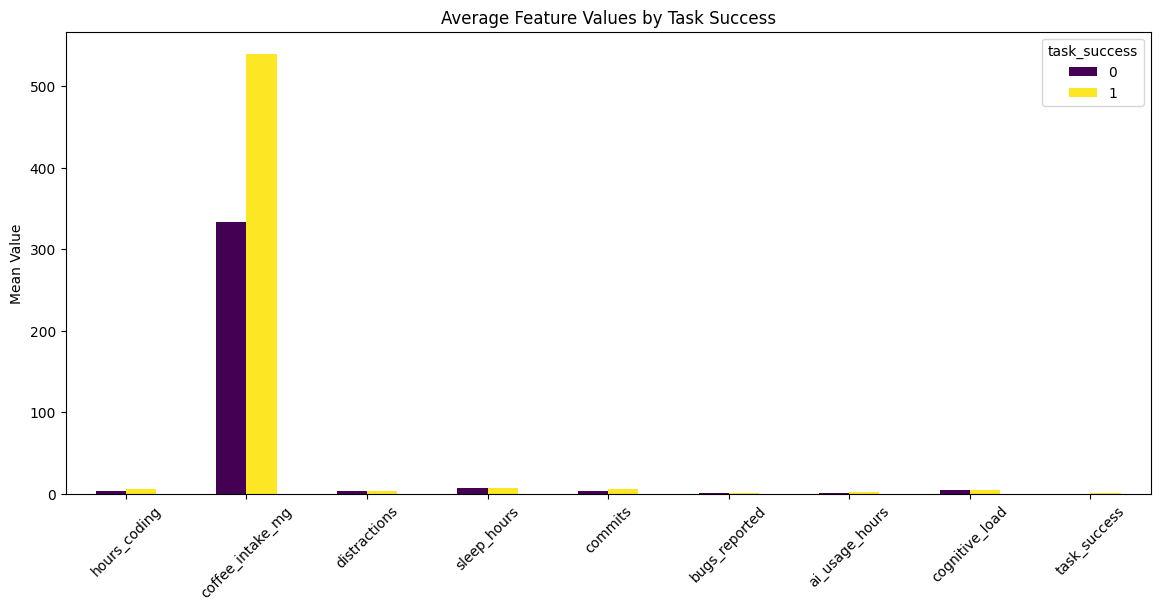

In [38]:
# ====== Pairplot (for small subset of numeric features) ======
subset_cols = num_cols[:5] + ["task_success"] if "task_success" in df.columns else num_cols[:5]
sns.pairplot(df[subset_cols], hue="task_success" if "task_success" in df.columns else None, diag_kind="kde", corner=True)
plt.suptitle("Pairplot of Selected Features", y=1.02)
plt.show()

# ====== Grouped analysis (mean feature values per target class) ======
if "task_success" in df.columns:
    grouped = df.groupby("task_success")[num_cols].mean().T
    plt.figure(figsize=(10,6))
    grouped.plot(kind="bar", figsize=(14,6), colormap="viridis")
    plt.title("Average Feature Values by Task Success")
    plt.ylabel("Mean Value")
    plt.xticks(rotation=45)
    plt.show()

**Loading the dataset Path**

In [39]:
CSV_PATH = "/kaggle/input/developer-productivity-syncora/Developer_Productivity_Synthetic_Syncora(in).csv"
TARGET   = "task_success"
RANDOM_STATE = 42

**Load dataset into Pandas**

In [40]:
df = pd.read_csv(CSV_PATH)
if TARGET not in df.columns:
    raise ValueError(f"Target '{TARGET}' not found. Columns: {list(df.columns)}")

**Splitting Features and Target**

We separate independent variables (X) and the dependent variable (y = task_success).

X → predictor features.

y → the binary classification target.


In [41]:
X = df.drop(columns=[TARGET])
y = df[TARGET].astype(int)

**Re-identify Numeric Columns**

In [42]:
num_cols = X.select_dtypes(include=[np.number]).columns.tolist()
cat_cols = [c for c in X.columns if c not in num_cols]

numeric_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler())
])
categorical_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent"))
    # If you add true categorical features later, append OneHotEncoder() here
])

preprocess = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, num_cols),
        ("cat", categorical_transformer, cat_cols),
    ],
    remainder="drop"
)

**Random Forest**

We create a baseline RandomForestClassifier with 300 estimators and default settings.Serves as our first supervised learning model.Random Forest is a strong baseline for tabular classification tasks due to robustness and interpretability.

In [43]:
rf_baseline = RandomForestClassifier(
    n_estimators=300, random_state=RANDOM_STATE, n_jobs=-1
)

pipe_baseline = Pipeline([
    ("preprocess", preprocess),
    ("rf", rf_baseline)
])

In [44]:
# ====== 5-fold CROSS-VALIDATION (baseline RF) ======
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)
scoring = {
    "accuracy": "accuracy",
    "f1": "f1",
    "precision": "precision",
    "recall": "recall",
    "roc_auc": "roc_auc",
}

cv_results = cross_validate(
    pipe_baseline, X, y, cv=cv, scoring=scoring, return_train_score=False, n_jobs=-1
)

def summarize_cv(cv_results):
    rows = []
    for k, v in cv_results.items():
        if k.startswith("test_"):
            metric = k.replace("test_", "")
            rows.append({
                "metric": metric,
                "mean": np.mean(v),
                "std": np.std(v)
            })
    df_cv = pd.DataFrame(rows).sort_values("metric").reset_index(drop=True)
    return df_cv

print("=== 5-fold Cross-Validation (Baseline Random Forest) ===")
df_cv = summarize_cv(cv_results)
display(df_cv)

=== 5-fold Cross-Validation (Baseline Random Forest) ===


,metric,mean,std
0,accuracy,0.988500,0.006042
1,f1,0.990659,0.004958
2,precision,0.992711,0.004650
3,recall,0.988670,0.009019
4,roc_auc,0.999632,0.000345


**Train–Test Split and Model Fitting**

Here we create a stratified train/test split and fit the pipeline on the training data.

Key points:

train_test_split(..., stratify=y, random_state=42) preserves class balance across splits, improving reliability of metrics.We fit the entire pipeline on X_train, y_train, so imputation/scaling are learned only from the training set (avoids leakage).

In [45]:
# ====== TRAIN/TEST SPLIT for tuning + final eval ======
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=RANDOM_STATE
)

In [46]:
# HYPERPARAMETER TUNING (RandomizedSearchCV) 
rf_for_tuning = RandomForestClassifier(random_state=RANDOM_STATE, n_jobs=-1)

pipe_tune = Pipeline([
    ("preprocess", preprocess),
    ("rf", rf_for_tuning)
])


**Hyperparameter Tuning**

This cell uses RandomizedSearchCV to find the best Random Forest settings.It tests different values for trees, depth, splits, leaves, features, and criteria.
The search runs with cross-validation, optimizing for F1-score.It prints the best score and the best parameters.

In [47]:
# Reasonable search space (kept compact for speed; expand if needed)
param_distributions = {
    "rf__n_estimators": [200, 300, 500, 800],
    "rf__max_depth": [None, 10, 15, 20, 30],
    "rf__min_samples_split": [2, 5, 10],
    "rf__min_samples_leaf": [1, 2, 4],
    "rf__max_features": ["sqrt", "log2", 0.7],
    "rf__bootstrap": [True],
    "rf__criterion": ["gini", "entropy", "log_loss"],
    # Uncomment if class imbalance is suspected:
    # "rf__class_weight": [None, "balanced"]
}

tuner = RandomizedSearchCV(
    estimator=pipe_tune,
    param_distributions=param_distributions,
    n_iter=30,            # increase for a more exhaustive search
    scoring="f1",         # optimize for F1 on '1' by default
    cv=cv,
    verbose=1,
    n_jobs=-1,
    random_state=RANDOM_STATE,
    refit=True
)

tuner.fit(X_train, y_train)

print("\n=== Best Tuning Result ===")
print(f"Best F1 (CV): {tuner.best_score_:.4f}")
print("Best Params:")
for k, v in tuner.best_params_.items():
    print(f"  {k}: {v}")

Fitting 5 folds for each of 30 candidates, totalling 150 fits

=== Best Tuning Result ===
Best F1 (CV): 0.9903
Best Params:
  rf__n_estimators: 800
  rf__min_samples_split: 2
  rf__min_samples_leaf: 1
  rf__max_features: sqrt
  rf__max_depth: 15
  rf__criterion: entropy
  rf__bootstrap: True


In [48]:
# Show top 10 configs from RandomizedSearchCV
cvres = pd.DataFrame(tuner.cv_results_)
cols = ["rank_test_score", "mean_test_score", "std_test_score", "params"]
top10 = cvres.sort_values("rank_test_score").head(10)[cols]
print("\n=== Top 10 Configurations (by F1 CV) ===")
display(top10)


=== Top 10 Configurations (by F1 CV) ===


,rank_test_score,mean_test_score,std_test_score,params
15,1,0.990335,0.004746,"{'rf__n_estimators': 800, 'rf__min_samples_spl..."
14,2,0.988793,0.005348,"{'rf__n_estimators': 200, 'rf__min_samples_spl..."
19,3,0.986240,0.006087,"{'rf__n_estimators': 300, 'rf__min_samples_spl..."
17,4,0.986237,0.006865,"{'rf__n_estimators': 300, 'rf__min_samples_spl..."
5,5,0.986219,0.006751,"{'rf__n_estimators': 300, 'rf__min_samples_spl..."
9,6,0.986217,0.006885,"{'rf__n_estimators': 800, 'rf__min_samples_spl..."
27,7,0.986193,0.007994,"{'rf__n_estimators': 500, 'rf__min_samples_spl..."
26,8,0.985765,0.004844,"{'rf__n_estimators': 800, 'rf__min_samples_spl..."
24,9,0.985754,0.005145,"{'rf__n_estimators': 200, 'rf__min_samples_spl..."
8,10,0.985738,0.006065,"{'rf__n_estimators': 300, 'rf__min_samples_spl..."


In [49]:
# ====== FINAL EVAL ON HELD-OUT TEST SET ======
best_model = tuner.best_estimator_
y_pred  = best_model.predict(X_test)
y_proba = best_model.predict_proba(X_test)[:, 1]

metrics_test = {
    "accuracy": accuracy_score(y_test, y_pred),
    "f1": f1_score(y_test, y_pred),
    "precision": precision_score(y_test, y_pred, zero_division=0),
    "recall": recall_score(y_test, y_pred),
    "roc_auc": roc_auc_score(y_test, y_proba),
}
print("\n=== Held-out Test Metrics (Tuned RF) ===")
for k, v in metrics_test.items():
    print(f"  {k:>9}: {v:.4f}")

print("\nClassification report (Tuned RF on Test):\n")
print(classification_report(y_test, y_pred, digits=4))


=== Held-out Test Metrics (Tuned RF) ===
   accuracy: 0.9900
         f1: 0.9919
  precision: 0.9880
     recall: 0.9960
    roc_auc: 0.9996

Classification report (Tuned RF on Test):

              precision    recall  f1-score   support

           0     0.9934    0.9804    0.9868       153
           1     0.9880    0.9960    0.9919       247

    accuracy                         0.9900       400
   macro avg     0.9907    0.9882    0.9894       400
weighted avg     0.9900    0.9900    0.9900       400

